In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,LSTM,Embedding,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from pickle import dump,load
%matplotlib inline

In [2]:
data_file = pd.read_csv('../../6 - NPL files/yelp_training_set_review(with text_length and transformed)-new.csv')
data_file = data_file[(data_file['stars'] == 1) | (data_file['stars'] == 5)].sample(frac=0.8).copy()
data_file = data_file[['stars', 'text_transformed']]

In [3]:
all_text = data_file['text_transformed'].values
all_text = all_text.astype('str')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)
sequences = tokenizer.texts_to_sequences(all_text)
count_unique = len(tokenizer.word_counts)
pad_encoded = pad_sequences(sequences, maxlen=100, truncating='post', padding='post')

In [4]:
X = np.array(pad_encoded)
y = pd.get_dummies(data_file['stars'], drop_first=True).values
seq_len = X.shape[1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
model = Sequential()
model.add(Embedding(count_unique+1, seq_len, input_length=seq_len)) # rescale the unique number for each token to be small decimal for nomalization; this has to be the first layer
model.add(LSTM(seq_len,return_sequences=True))
model.add(Dropout(0.5))
#model.add(LSTM(round(seq_len/5)))
#model.add(Dense(50,activation='relu'))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          6790700   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 100)          80400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 6,881,101
Trainable params: 6,881,101
Non-trainable params: 0
_________________________________________________________________


In [7]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           patience=10)

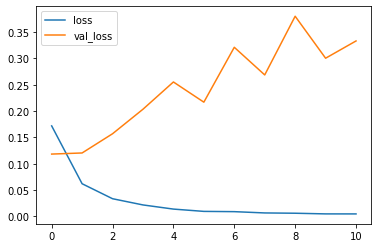

In [8]:
history = model.fit(X_train,y_train,
                    batch_size=128,
                    epochs=50,
                    verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop]
                   )
model.save('keras_lstm.h5')
data_history = pd.DataFrame(history.history)
data_history[['loss','val_loss']].plot()

In [9]:
dump(tokenizer,open('keras_lstm_tokenizer','wb'))
model = load_model('keras_lstm.h5')
tokenizer = load(open('keras_lstm_tokenizer','br'))

In [10]:
test = ['very nice food','terrible','I didn''t waited so long for this meal']
test_encoded = tokenizer.texts_to_sequences(test)
print(test_encoded)
test_padded = pad_sequences(test_encoded, maxlen=100, padding='post')
print(test_padded)
model.predict_classes(test_padded)

[[23, 2], [639], [1584, 513, 107, 92]]
[[  23    2    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 639    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 

array([[1],
       [0],
       [0]], dtype=int32)